In [1]:
%cd ..

/nfs/scistore16/edelgrp/fzimin/depth-poset


/mnt/nfs/clustersw/Debian/bookworm/jupyterhub/1.0/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [2]:
import os

import numpy as np
import pandas as pd
import pickle as pkl
import networkx as nx
import gudhi as gh

from src.depth import DepthPoset


#from tqdm.notebook import tqdm
from tqdm import tqdm

from matplotlib import pyplot as plt
from matplotlib import cm
from networkx import draw_networkx
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from matplotlib import lines as mlines

from src.depth import DepthPoset

# Create directory for the pics

In [3]:
path = 'raports/pics/torus scores'

if not os.path.exists(path):
    os.makedirs(path)

# Load and Format the Data

In [4]:
# define file paths
directory = "results/scores-on-barycentric-cubical-toruses"
paths = np.sort([f'{directory}/{f}' for f in os.listdir(directory)])

paths = paths[pd.Series(paths).apply(lambda s: s.split('.')[0].split('/')[-1]).values > '2024-12-26 18:04:00']

# load them
ls = []
for path in tqdm(paths, total=len(paths)):
    with open(path, 'rb') as file:
        ls.append(pkl.load(file))
        ls[-1].update({'path': path})

100%|██████████| 361/361 [00:01<00:00, 234.60it/s]


100%|██████████| 360/360 [00:01<00:00, 348.80it/s]


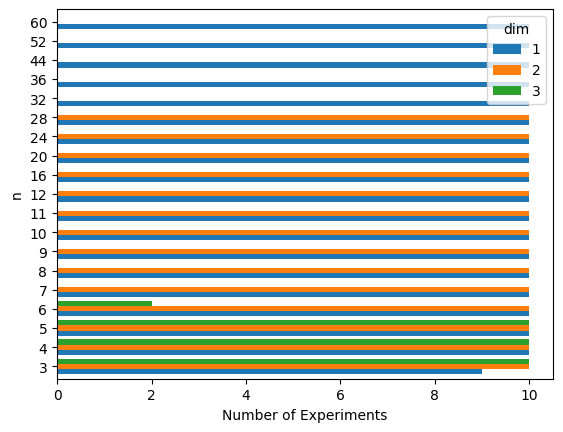

In [5]:
df_cases = pd.DataFrame(ls)
df_cases.insert(0, 'index', df_cases.index)

df_cases[['n', 'dim', 'depth poset']].groupby(['n', 'dim']).count().reset_index().pivot(columns='dim', index='n', values='depth poset').fillna(0).astype(int).plot(kind='barh', width=0.8)
plt.xlabel('Number of Experiments')
plt.savefig('raports/pics/torus scores/cases.png')

In [6]:
print(f'df_cases.shape = {df_cases.shape}')
df_cases.head()

df_cases.shape = (361, 9)


index  n  dim shape                                            complex  \
0      0  4    1  (4,)  <src.complexes.CubicalTorusComplex object at 0...   
1      1  4    1  (4,)  <src.complexes.CubicalTorusComplex object at 0...   
2      2  5    1  (5,)  <src.complexes.CubicalTorusComplex object at 0...   
3      3  4    1  (4,)  <src.complexes.CubicalTorusComplex object at 0...   
4      4  4    1  (4,)  <src.complexes.CubicalTorusComplex object at 0...   

                                       depth poset  \
0  <src.depth.DepthPoset object at 0x7effcdc72e10>   
1  <src.depth.DepthPoset object at 0x7effcc96c450>   
2  <src.depth.DepthPoset object at 0x7effcc96d590>   
3  <src.depth.DepthPoset object at 0x7f004c03ec50>   
4  <src.depth.DepthPoset object at 0x7effcc96fe50>   

                                        poset scores  \
0  [{'object': 'full', 'avarage_maximal_chain': 1...   
1  [{'object': 'full', 'avarage_maximal_chain': 1...   
2  [{'object': 'full', 'avarage_maximal_chain': 1...   
3  [{'object': 'full', 'avarage_maximal_chain': 1...   
4  [{'object': 'full', 'avarage_maximal_chain': 1...   

                                         node scores  \
0  [{'object': 'full', 'node': (0,),((0,),(1,)), ...   
1  [{'object': 'full', 'node': (1,),((1,),(2,)), ...   
2  [{'object': 'full', 'node': (2,),((1,),(2,)), ...   
3  [{'object': 'full', 'node': (0,),((2,),(3,)), ...   
4  [{'object': 'full', 'node': (0,),((3,),(0,)), ...   

                                                path  
0  results/scores-on-barycentric-cubical-toruses/...  
1  results/scores-on-barycentric-cubical-toruses/...  
2  results/scores-on-barycentric-cubical-toruses/...  
3  results/scores-on-barycentric-cubical-toruses/...  
4  results/scores-on-barycentric-cubical-toruses/...

## Geting pairs for homotopies

In [7]:
import itertools

In [8]:
max_pairs = 30

pairs = df_cases.groupby(['dim', 'shape'])['path'].agg(lambda l: np.array(list(itertools.combinations(l, 2))))
pairs = pairs.apply(lambda l: l if len(l) <= max_pairs else l[np.sort(np.random.choice(np.arange(len(l)), max_pairs, replace=False))])
pairs = np.concatenate([p for p in pairs.values if len(p) > 0])

print(f'pairs.shape = {pairs.shape}')
pairs[:5]

pairs.shape = (1081, 2)


array([['results/scores-on-barycentric-cubical-toruses/2025-06-18 16:08:54.877695.pkl',
        'results/scores-on-barycentric-cubical-toruses/2025-06-18 16:08:54.877886.pkl'],
       ['results/scores-on-barycentric-cubical-toruses/2025-06-18 16:08:54.877695.pkl',
        'results/scores-on-barycentric-cubical-toruses/2025-06-18 16:08:54.878118.pkl'],
       ['results/scores-on-barycentric-cubical-toruses/2025-06-18 16:08:54.877695.pkl',
        'results/scores-on-barycentric-cubical-toruses/2025-06-18 16:08:54.883683.pkl'],
       ['results/scores-on-barycentric-cubical-toruses/2025-06-18 16:08:54.877695.pkl',
        'results/scores-on-barycentric-cubical-toruses/2025-06-18 16:08:54.886476.pkl'],
       ['results/scores-on-barycentric-cubical-toruses/2025-06-18 16:08:54.877695.pkl',
        'results/scores-on-barycentric-cubical-toruses/2025-06-18 16:08:54.886544.pkl']],
      dtype='<U76')

In [9]:
s = '\n'.join([f'"{f0}" "{f1}"' for f0, f1 in pairs]) + '\n'
#print(s)

# The example of the filtration $f: \mathbb{T}^2\to\mathbb{R}$

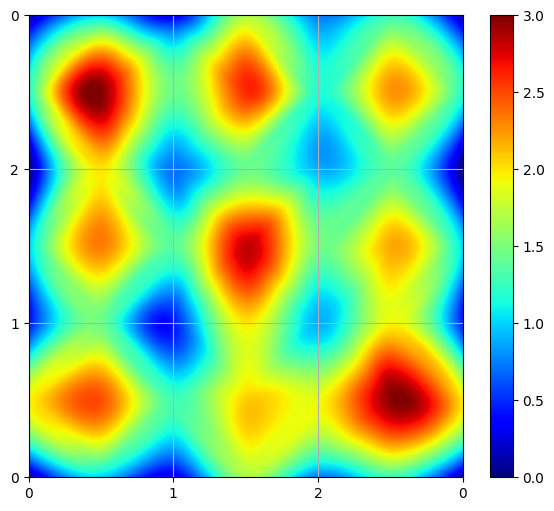

In [10]:
ctc = np.random.choice(df_cases[(df_cases['dim'] == 2)&(df_cases['n'] <= 6)]['complex'])
n = ctc.shape[0]

fig, ax = plt.subplots(figsize=(7, 6))

sm = ctc.draw_gradiental(ax=ax, vmin=0, vmax=3)
plt.colorbar(sm, ax=ax)

ax.set_xticks(np.arange(n + 1), np.arange(n + 1)%n)
ax.set_yticks(np.arange(n + 1), np.arange(n + 1)%n)
ax.grid(True)

plt.savefig('raports/pics/torus scores/2d-example.png')

# Plot Poset Scores

In [11]:
from src import poset_scores

In [12]:
df_poset_scores = [pd.DataFrame(i['poset scores']) for i in ls]
for i in range(len(df_poset_scores)):
    df_poset_scores[i].insert(0, 'index', value=i)
df_poset_scores = pd.concat(df_poset_scores)

df_poset_scores = df_cases[['index', 'n', 'dim']].join(df_poset_scores.set_index('index'), on='index')
df_poset_scores = df_poset_scores.reset_index(drop=True)

print(f'df_poset_scores.shape = {df_poset_scores.shape}')
df_poset_scores.head(12)

df_poset_scores.shape = (2778, 16)


index  n  dim                           object  avarage_maximal_chain  \
0       0  4    1                             full                    1.0   
1       0  4    1                   subposet dim=0                    1.0   
2       0  4    1                 column reduction                    1.0   
3       0  4    1  column reduction subposet dim=0                    1.0   
4       0  4    1                    row reduction                    1.0   
5       0  4    1     row reduction subposet dim=0                    1.0   
6       1  4    1                             full                    1.5   
7       1  4    1                   subposet dim=0                    1.5   
8       1  4    1                 column reduction                    1.0   
9       1  4    1  column reduction subposet dim=0                    1.0   
10      1  4    1                    row reduction                    1.5   
11      1  4    1     row reduction subposet dim=0                    1.5   

    cycles_dimension  height  minimum_maximal_chain  number_of_components  \
0                  0       0                      1                     3   
1                  0       0                      1                     3   
2                  0       0                      1                     3   
3                  0       0                      1                     3   
4                  0       0                      1                     3   
5                  0       0                      1                     3   
6                  0       1                      1                     2   
7                  0       1                      1                     2   
8                  0       0                      1                     3   
9                  0       0                      1                     3   
10                 0       1                      1                     2   
11                 0       1                      1                     2   

    number_of_edges_in_closure  number_of_edges_in_reduction  \
0                            0                             0   
1                            0                             0   
2                            0                             0   
3                            0                             0   
4                            0                             0   
5                            0                             0   
6                            1                             1   
7                            1                             1   
8                            0                             0   
9                            0                             0   
10                           1                             1   
11                           1                             1   

    number_of_maximal_nodes  number_of_minimal_nodes  number_of_nodes  \
0                         3                        3                3   
1                         3                        3                3   
2                         3                        3                3   
3                         3                        3                3   
4                         3                        3                3   
5                         3                        3                3   
6                         2                        2                3   
7                         2                        2                3   
8                         3                        3                3   
9                         3                        3                3   
10                        2                        2                3   
11                        2                        2                3   

    number_of_relations  width  
0                     0      3  
1                     0      3  
2                     0      3  
3                     0      3  
4                     0      3  
5                  

In [13]:
interesting_poset_scores = [poset_scores.number_of_nodes, 
                            poset_scores.number_of_relations, 
                            poset_scores.number_of_components, 
                            poset_scores.cycles_dimension, 
                            poset_scores.number_of_minimal_nodes, 
                            poset_scores.number_of_maximal_nodes, 
                            poset_scores.height, 
                            poset_scores.width, 
                            poset_scores.minimum_maximal_chain, 
                            poset_scores.avarage_maximal_chain
                           ]
interesting_poset_scores_names = [score.__name__ for score in interesting_poset_scores]

for score in interesting_poset_scores:
    if not (score.__name__ in df_poset_scores.columns):
        df_poset_scores[score.__name__] = np.nan

missed_values = df_poset_scores[[score.__name__ for score in interesting_poset_scores]].isna().sum().sum()
print(f'There are {missed_values} values missed and should be restored.')

with tqdm(total=missed_values) as pbar:
    for i in df_poset_scores[df_poset_scores[interesting_poset_scores_names].isna().any(axis=1)].index:
        if df_poset_scores.loc[i, interesting_poset_scores_names].isna().any():
            dp = df_cases.loc[df_cases['index'] == df_poset_scores.loc[i, 'index'], 'depth poset'].values[0]
            if df_poset_scores.loc[i, 'object'] != 'full':
                dim = int(df_poset_scores.loc[i, 'object'].replace('subposet dim=', ''))
                dp = dp.subposet_dim(dim)
            for score in interesting_poset_scores:
                if pd.isna(df_poset_scores.loc[i, score.__name__]):
                    df_poset_scores.loc[i, score.__name__] = score(dp)
                    pbar.update()
        
print(f'df_poset_scores.shape = {df_poset_scores.shape}')
df_poset_scores.head()

There are 0 values missed and should be restored.


0it [00:00, ?it/s]

df_poset_scores.shape = (2778, 16)


index  n  dim                           object  avarage_maximal_chain  \
0      0  4    1                             full                    1.0   
1      0  4    1                   subposet dim=0                    1.0   
2      0  4    1                 column reduction                    1.0   
3      0  4    1  column reduction subposet dim=0                    1.0   
4      0  4    1                    row reduction                    1.0   

   cycles_dimension  height  minimum_maximal_chain  number_of_components  \
0                 0       0                      1                     3   
1                 0       0                      1                     3   
2                 0       0                      1                     3   
3                 0       0                      1                     3   
4                 0       0                      1                     3   

   number_of_edges_in_closure  number_of_edges_in_reduction  \
0                           0                             0   
1                           0                             0   
2                           0                             0   
3                           0                             0   
4                           0                             0   

   number_of_maximal_nodes  number_of_minimal_nodes  number_of_nodes  \
0                        3                        3                3   
1                        3                        3                3   
2                        3                        3                3   
3                        3                        3                3   
4                        3                        3                3   

   number_of_relations  width  
0                    0      3  
1                    0      3  
2                    0      3  
3                    0      3  
4                    0      3

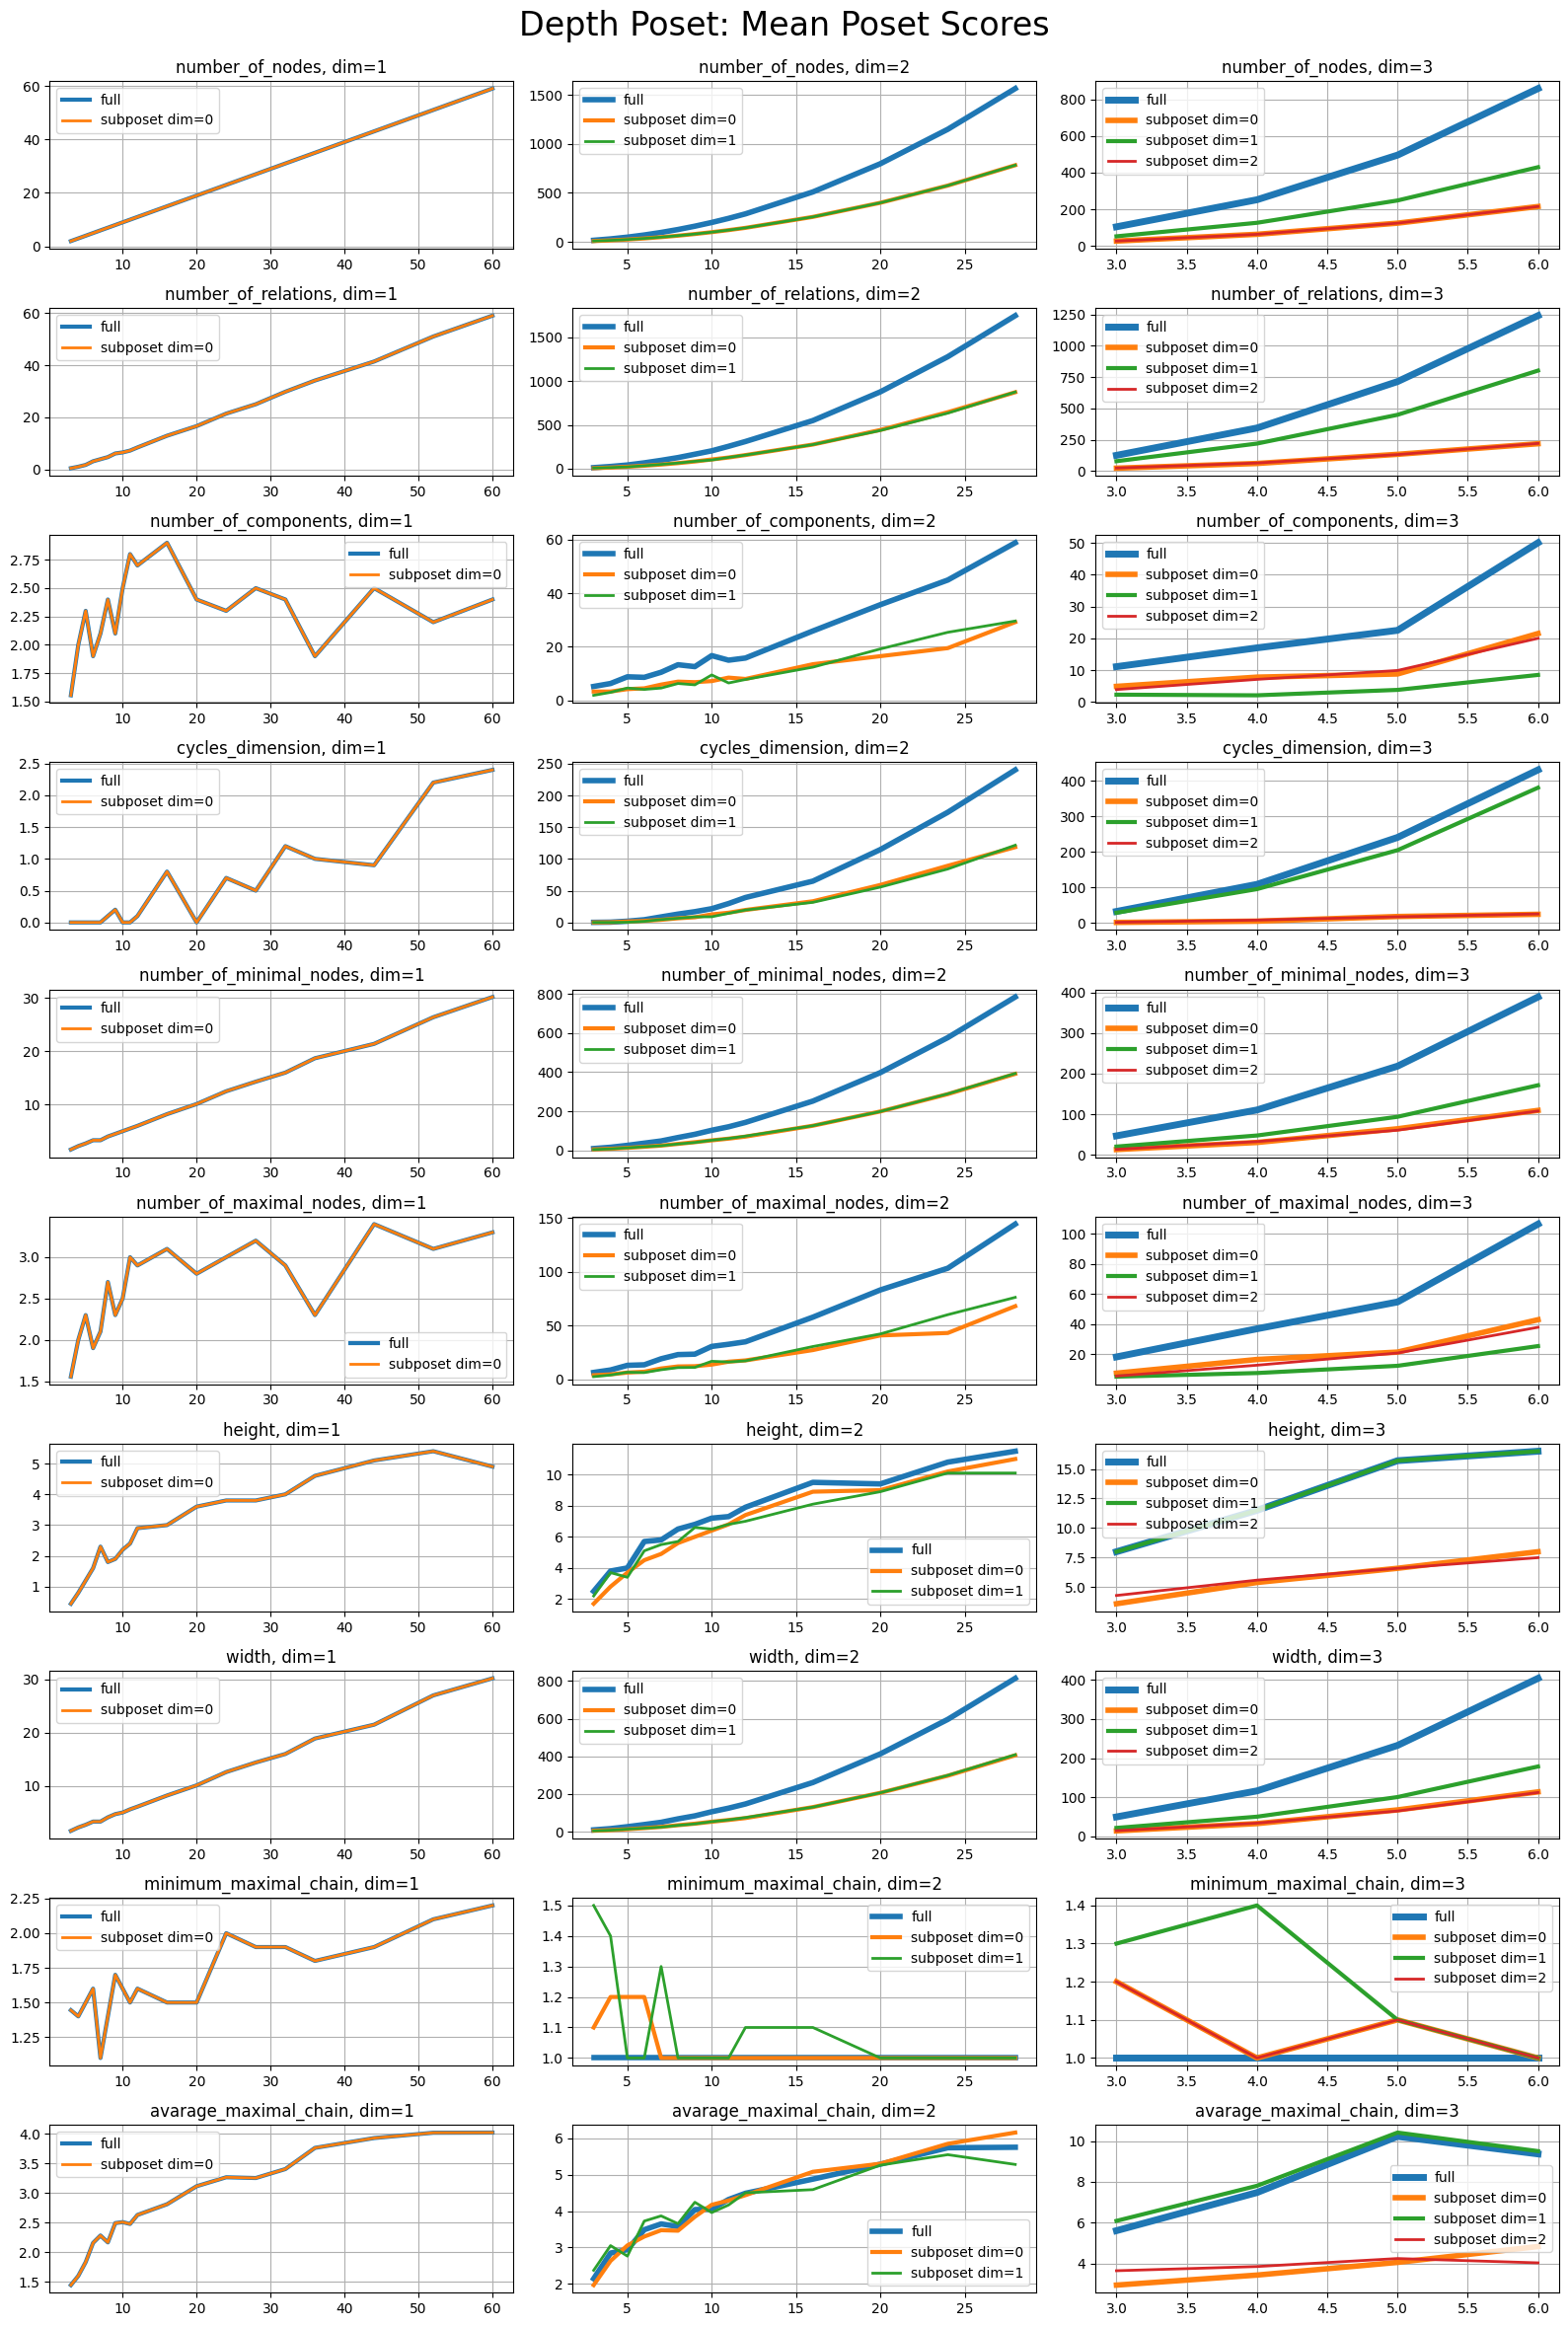

In [14]:
score_cols = interesting_poset_scores_names
max_dim = df_poset_scores['dim'].max()

fig, axs = plt.subplots(len(score_cols), max_dim)

# define the dataframe with interesting objects
objects = ['full'] + [f'subposet dim={dim}' for dim in range(max_dim + 1)]
df_objects = df_poset_scores[df_poset_scores['object'].isin(objects)]

fig.suptitle('Depth Poset: Mean Poset Scores', fontsize=24)
fig.set_figwidth(16)
fig.set_figheight(24)

for iscore, score in enumerate(score_cols):
    for dim in range(1, max_dim + 1):
        title = f'{score}, dim={dim}'
        axs[iscore, dim - 1].set_title(title)
        #df_use = df_poset_scores[df_poset_scores['dim'] == dim][['n', 'object', score]].groupby(['n', 'object']).mean().reset_index().pivot(columns='object', index='n', values=score)
        df_use = df_objects[df_objects['dim'] == dim][['n', 'object', score]].groupby(['n', 'object']).mean().reset_index().pivot(columns='object', index='n', values=score)
        for icol, col in enumerate(df_use.columns):
            axs[iscore, dim - 1].plot(df_use.index, df_use[col], label=col, linewidth=(len(df_use.columns) + 1 - icol))
        axs[iscore, dim - 1].legend()
        axs[iscore, dim - 1].grid(True)
        
plt.tight_layout()
plt.subplots_adjust(top=0.95)

plt.savefig('raports/pics/torus scores/mean poset scores.png')

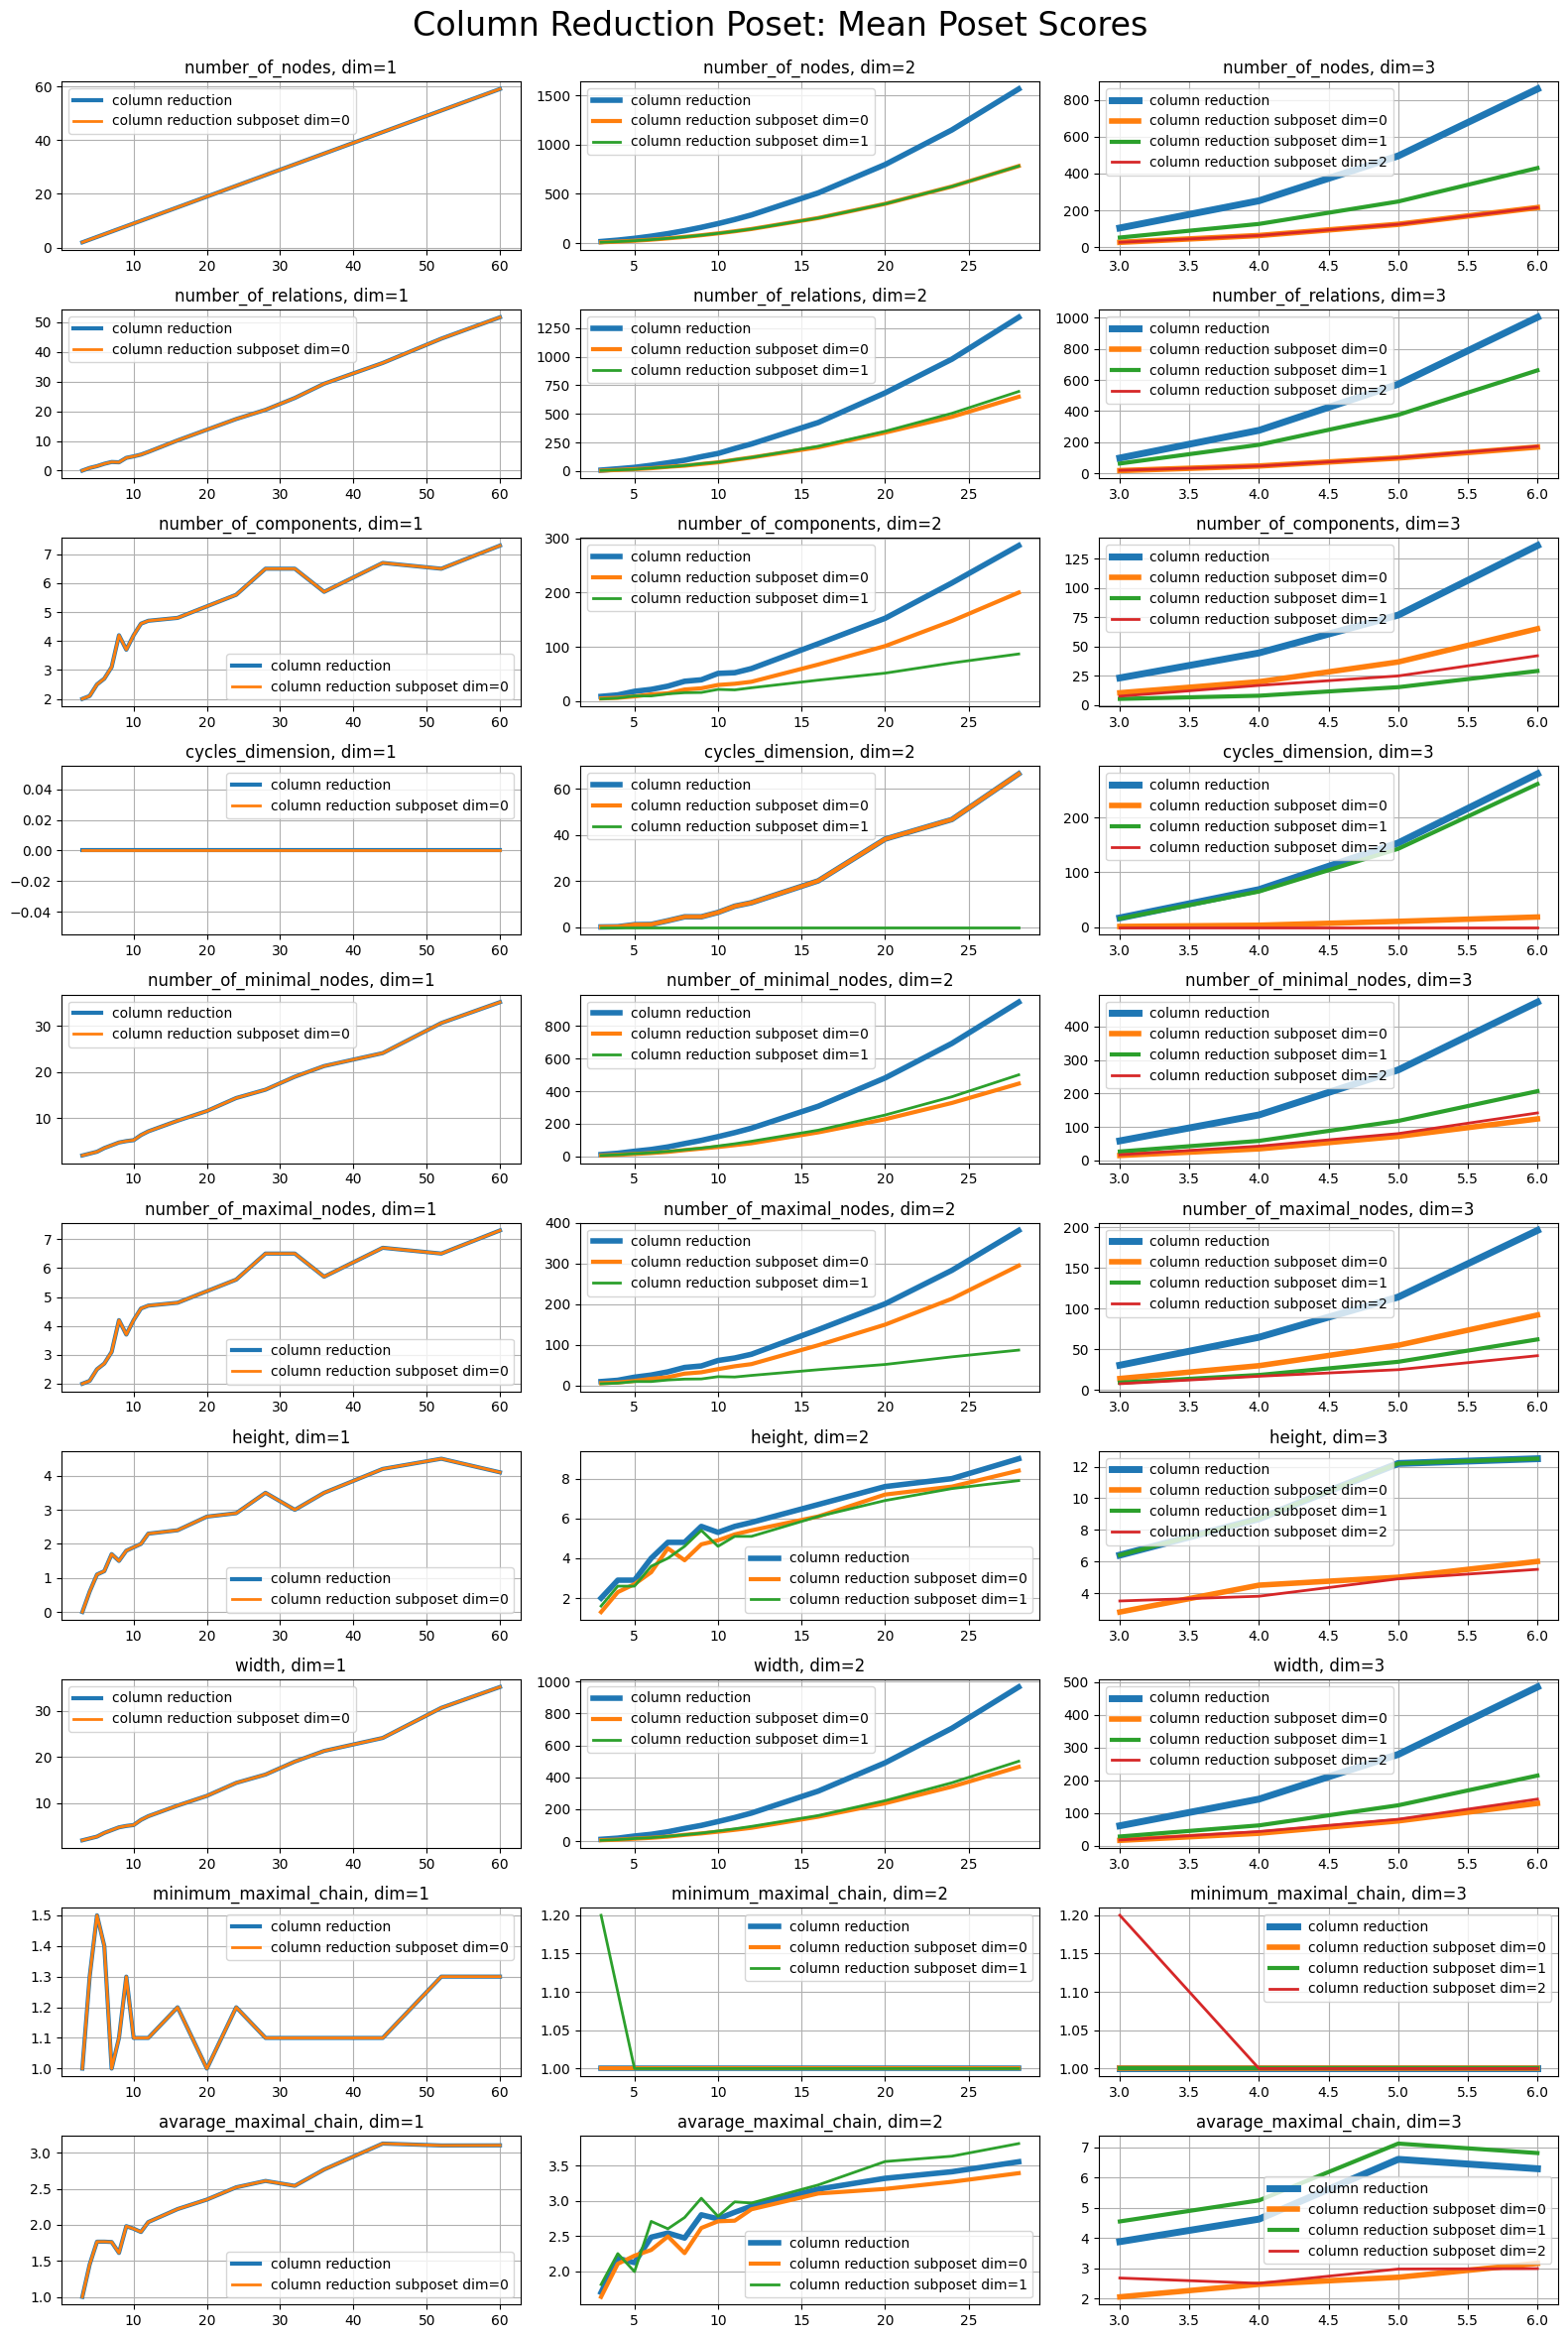

In [15]:
score_cols = interesting_poset_scores_names
max_dim = df_poset_scores['dim'].max()

fig, axs = plt.subplots(len(score_cols), max_dim)

# define the dataframe with interesting objects
objects = ['column reduction'] + [f'column reduction subposet dim={dim}' for dim in range(max_dim + 1)]
df_objects = df_poset_scores[df_poset_scores['object'].isin(objects)]

fig.suptitle('Column Reduction Poset: Mean Poset Scores', fontsize=24)
fig.set_figwidth(16)
fig.set_figheight(24)

for iscore, score in enumerate(score_cols):
    for dim in range(1, max_dim + 1):
        title = f'{score}, dim={dim}'
        axs[iscore, dim - 1].set_title(title)
        #df_use = df_poset_scores[df_poset_scores['dim'] == dim][['n', 'object', score]].groupby(['n', 'object']).mean().reset_index().pivot(columns='object', index='n', values=score)
        df_use = df_objects[df_objects['dim'] == dim][['n', 'object', score]].groupby(['n', 'object']).mean().reset_index().pivot(columns='object', index='n', values=score)
        for icol, col in enumerate(df_use.columns):
            axs[iscore, dim - 1].plot(df_use.index, df_use[col], label=col, linewidth=(len(df_use.columns) + 1 - icol))
        axs[iscore, dim - 1].legend()
        axs[iscore, dim - 1].grid(True)
        
plt.tight_layout()
plt.subplots_adjust(top=0.95)

plt.savefig('raports/pics/torus scores/mean poset scores - column reduction.png')

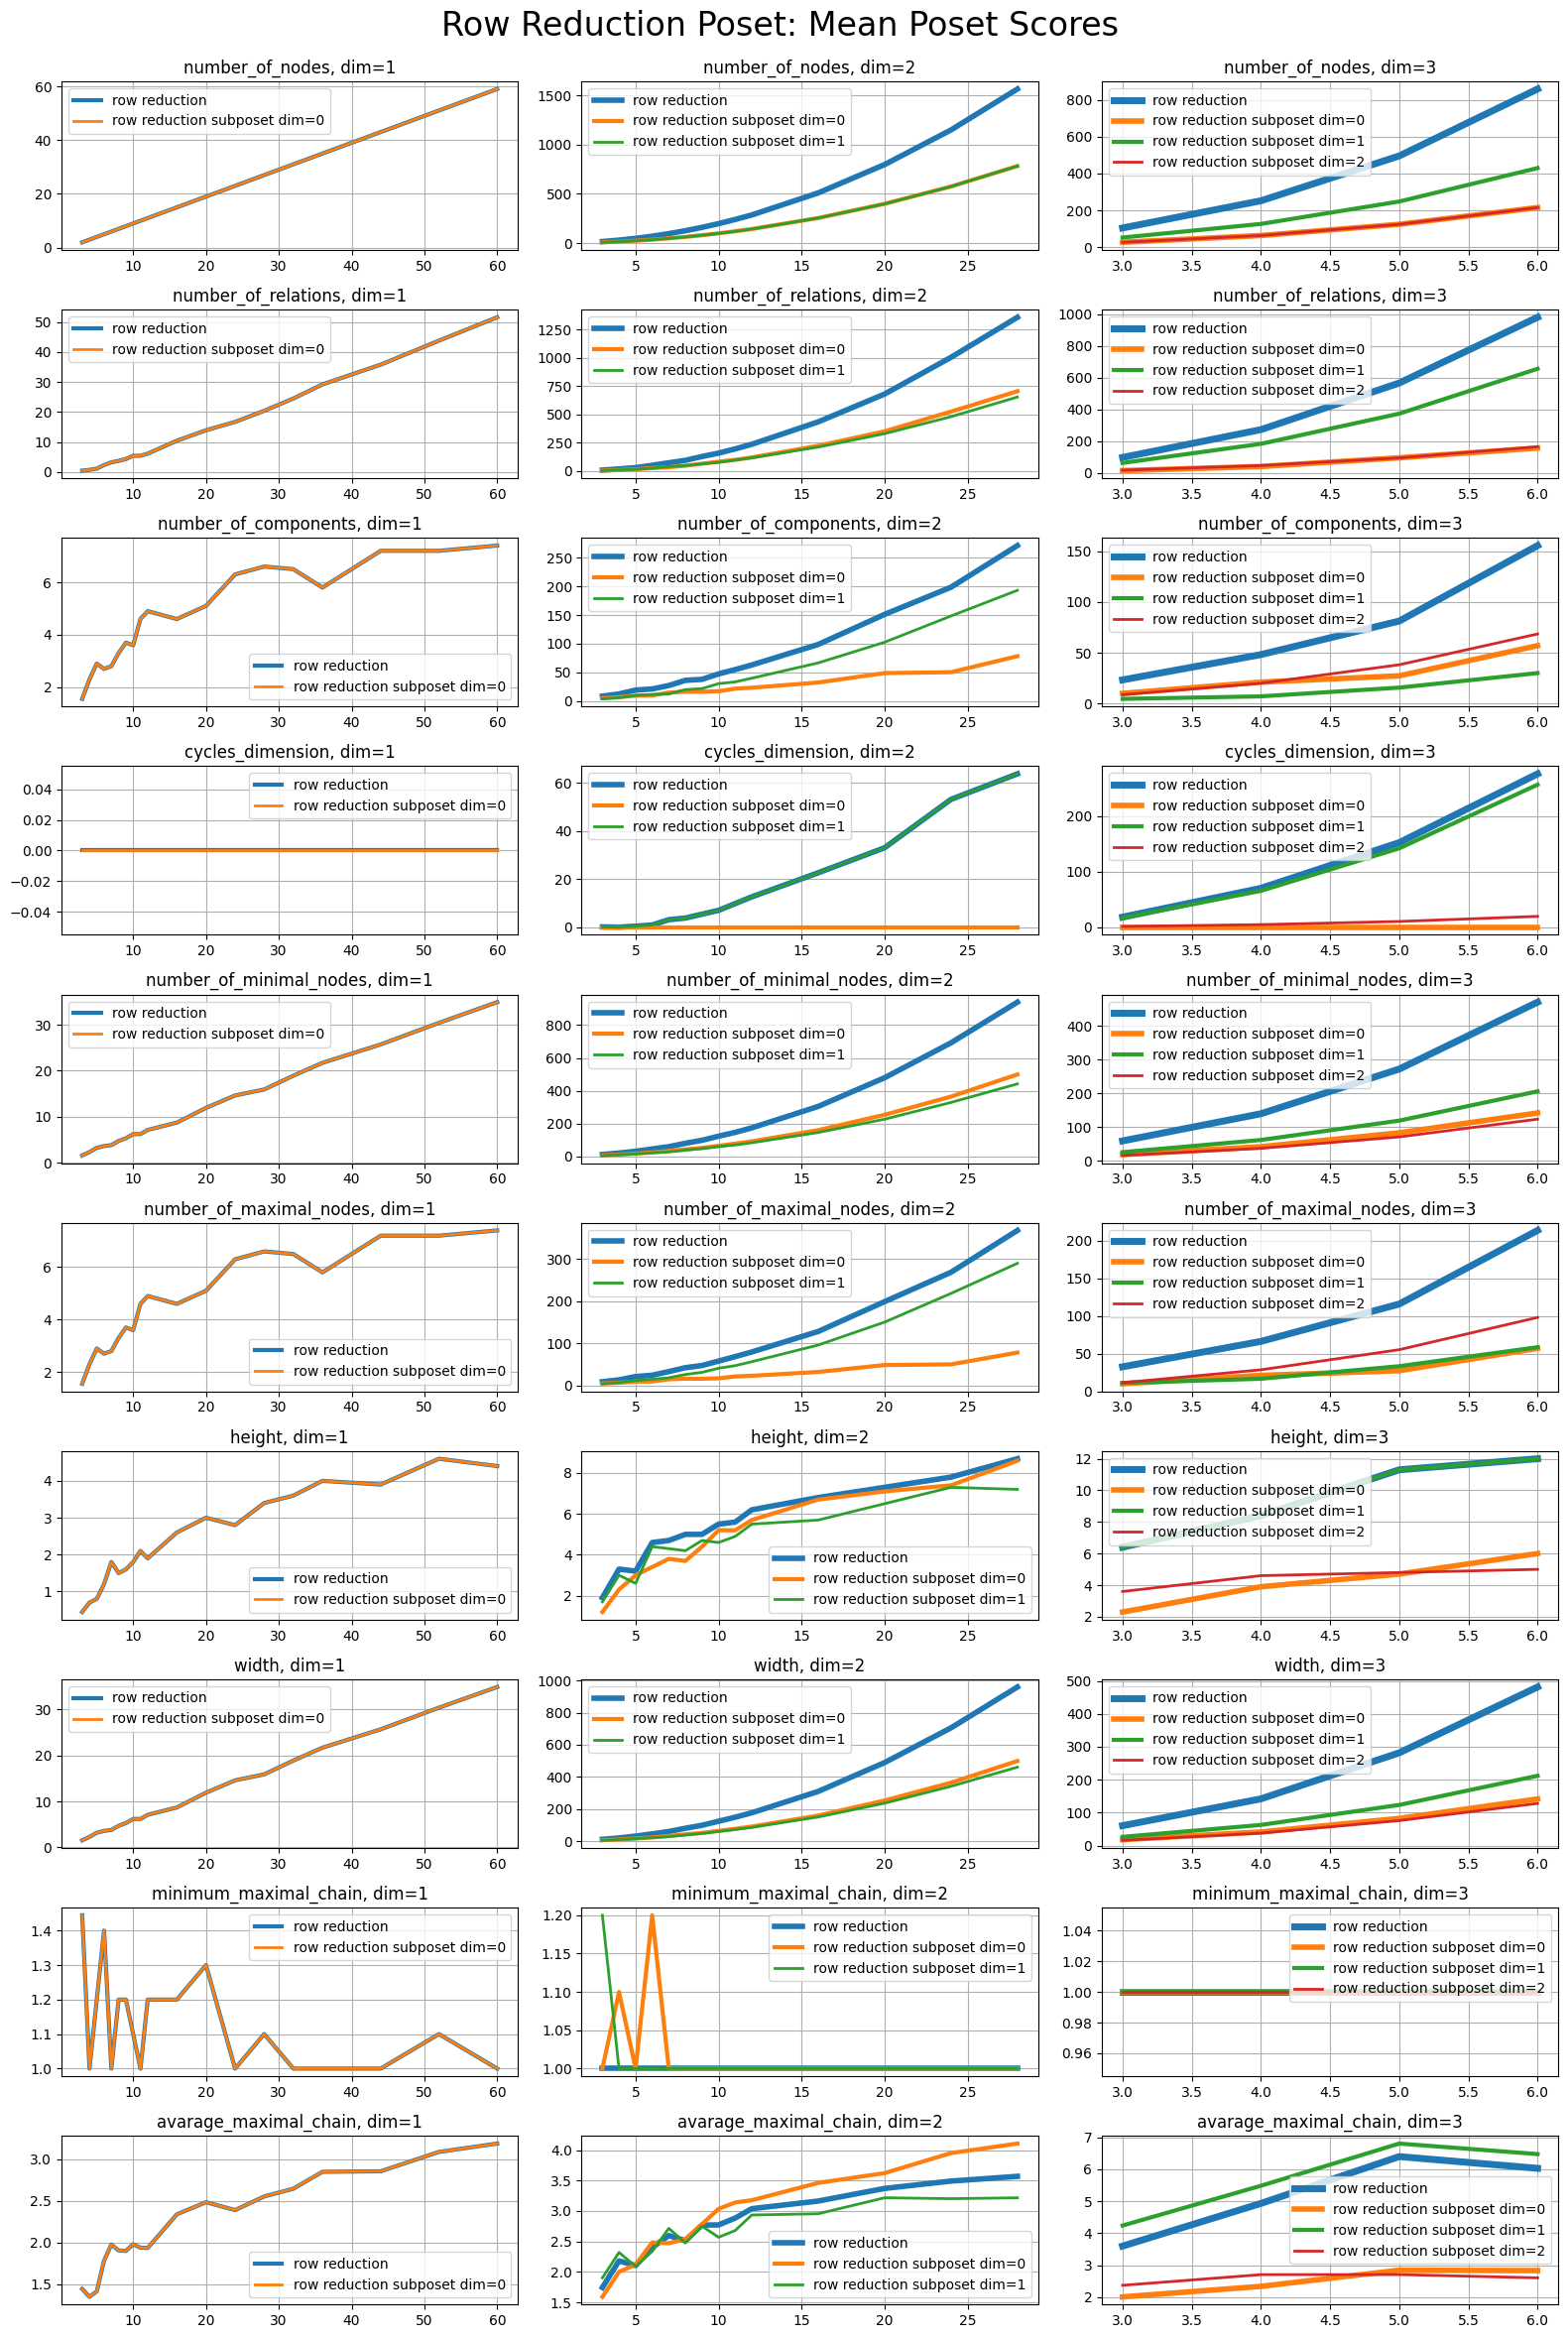

In [16]:
score_cols = interesting_poset_scores_names
max_dim = df_poset_scores['dim'].max()

fig, axs = plt.subplots(len(score_cols), max_dim)

# define the dataframe with interesting objects
objects = ['row reduction'] + [f'row reduction subposet dim={dim}' for dim in range(max_dim + 1)]
df_objects = df_poset_scores[df_poset_scores['object'].isin(objects)]

fig.suptitle('Row Reduction Poset: Mean Poset Scores', fontsize=24)
fig.set_figwidth(16)
fig.set_figheight(24)

for iscore, score in enumerate(score_cols):
    for dim in range(1, max_dim + 1):
        title = f'{score}, dim={dim}'
        axs[iscore, dim - 1].set_title(title)
        #df_use = df_poset_scores[df_poset_scores['dim'] == dim][['n', 'object', score]].groupby(['n', 'object']).mean().reset_index().pivot(columns='object', index='n', values=score)
        df_use = df_objects[df_objects['dim'] == dim][['n', 'object', score]].groupby(['n', 'object']).mean().reset_index().pivot(columns='object', index='n', values=score)
        for icol, col in enumerate(df_use.columns):
            axs[iscore, dim - 1].plot(df_use.index, df_use[col], label=col, linewidth=(len(df_use.columns) + 1 - icol))
        axs[iscore, dim - 1].legend()
        axs[iscore, dim - 1].grid(True)
        
plt.tight_layout()
plt.subplots_adjust(top=0.95)

plt.savefig('raports/pics/torus scores/mean poset scores - row reduction.png')

# Plot Node Scores

In [17]:
from src import node_scores

In [18]:
df_node_scores = [pd.DataFrame(i['node scores']) for i in ls]
for i in range(len(df_node_scores)):
    df_node_scores[i].insert(0, 'index', value=i)
df_node_scores = pd.concat(df_node_scores)


df_node_scores = df_cases[['index', 'n', 'dim']].join(df_node_scores.set_index('index'), on='index').reset_index(drop=True)

print(f'df_node_scores.shape = {df_node_scores.shape}')
df_node_scores.head()

df_node_scores.shape = (28980, 14)


index  n  dim                           object              node  \
0      0  4    1                             full  (0,),((0,),(1,))   
1      0  4    1                   subposet dim=0  (0,),((0,),(1,))   
2      0  4    1                 column reduction  (0,),((0,),(1,))   
3      0  4    1  column reduction subposet dim=0  (0,),((0,),(1,))   
4      0  4    1                    row reduction  (0,),((0,),(1,))   

   ancestors_cycles_dimension  ancestors_height  ancestors_number  \
0                           0                 0                 0   
1                           0                 0                 0   
2                           0                 0                 0   
3                           0                 0                 0   
4                           0                 0                 0   

   ancestors_width  incomparable_number  successors_cycles_dimension  \
0                0                    2                            0   
1                0                    2                            0   
2                0                    2                            0   
3                0                    2                            0   
4                0                    2                            0   

   successors_height  successors_number  successors_width  
0                  0                  0                 0  
1                  0                  0                 0  
2                  0                  0                 0  
3                  0                  0                 0  
4                  0                  0                 0

In [19]:
interesting_node_scores = [node_scores.ancestors_number,
                           node_scores.ancestors_height, 
                           node_scores.ancestors_width, 
                           node_scores.ancestors_cycles_dimension, 
                           node_scores.successors_number,
                           node_scores.successors_height,
                           node_scores.successors_width, 
                           node_scores.successors_cycles_dimension, 
                           ]
interesting_node_scores_names = [score.__name__ for score in interesting_node_scores]

for score in interesting_node_scores:
    if not (score.__name__ in df_node_scores.columns):
        df_node_scores[score.__name__] = np.nan

missed_values = df_node_scores[[score.__name__ for score in interesting_node_scores]].isna().sum().sum()
print(f'There are {missed_values} values missed and should be restored.')

with tqdm(total=missed_values) as pbar:
    for i in df_node_scores[df_node_scores[interesting_node_scores_names].isna().any(axis=1)].index:
        if df_node_scores.loc[i, interesting_node_scores_names].isna().any():
            dp = df_cases.loc[df_cases['index'] == df_node_scores.loc[i, 'index'], 'depth poset'].values[0]
            node = df_node_scores.loc[i, 'node']
            if df_node_scores.loc[i, 'object'] != 'full':
                dp_dim = int(df_node_scores.loc[i, 'object'].replace('subposet dim=', ''))
                dp = dp.subposet_dim(dp_dim)
            for score in interesting_node_scores:
                if pd.isna(df_node_scores.loc[i, score.__name__]):
                    df_node_scores.loc[i, score.__name__] = score(dp, node)
                    pbar.update()
        
print(f'df_node_scores.shape = {df_node_scores.shape}')
df_node_scores.head()

There are 0 values missed and should be restored.


0it [00:00, ?it/s]

df_node_scores.shape = (28980, 14)


index  n  dim                           object              node  \
0      0  4    1                             full  (0,),((0,),(1,))   
1      0  4    1                   subposet dim=0  (0,),((0,),(1,))   
2      0  4    1                 column reduction  (0,),((0,),(1,))   
3      0  4    1  column reduction subposet dim=0  (0,),((0,),(1,))   
4      0  4    1                    row reduction  (0,),((0,),(1,))   

   ancestors_cycles_dimension  ancestors_height  ancestors_number  \
0                           0                 0                 0   
1                           0                 0                 0   
2                           0                 0                 0   
3                           0                 0                 0   
4                           0                 0                 0   

   ancestors_width  incomparable_number  successors_cycles_dimension  \
0                0                    2                            0   
1                0                    2                            0   
2                0                    2                            0   
3                0                    2                            0   
4                0                    2                            0   

   successors_height  successors_number  successors_width  
0                  0                  0                 0  
1                  0                  0                 0  
2                  0                  0                 0  
3                  0                  0                 0  
4                  0                  0                 0

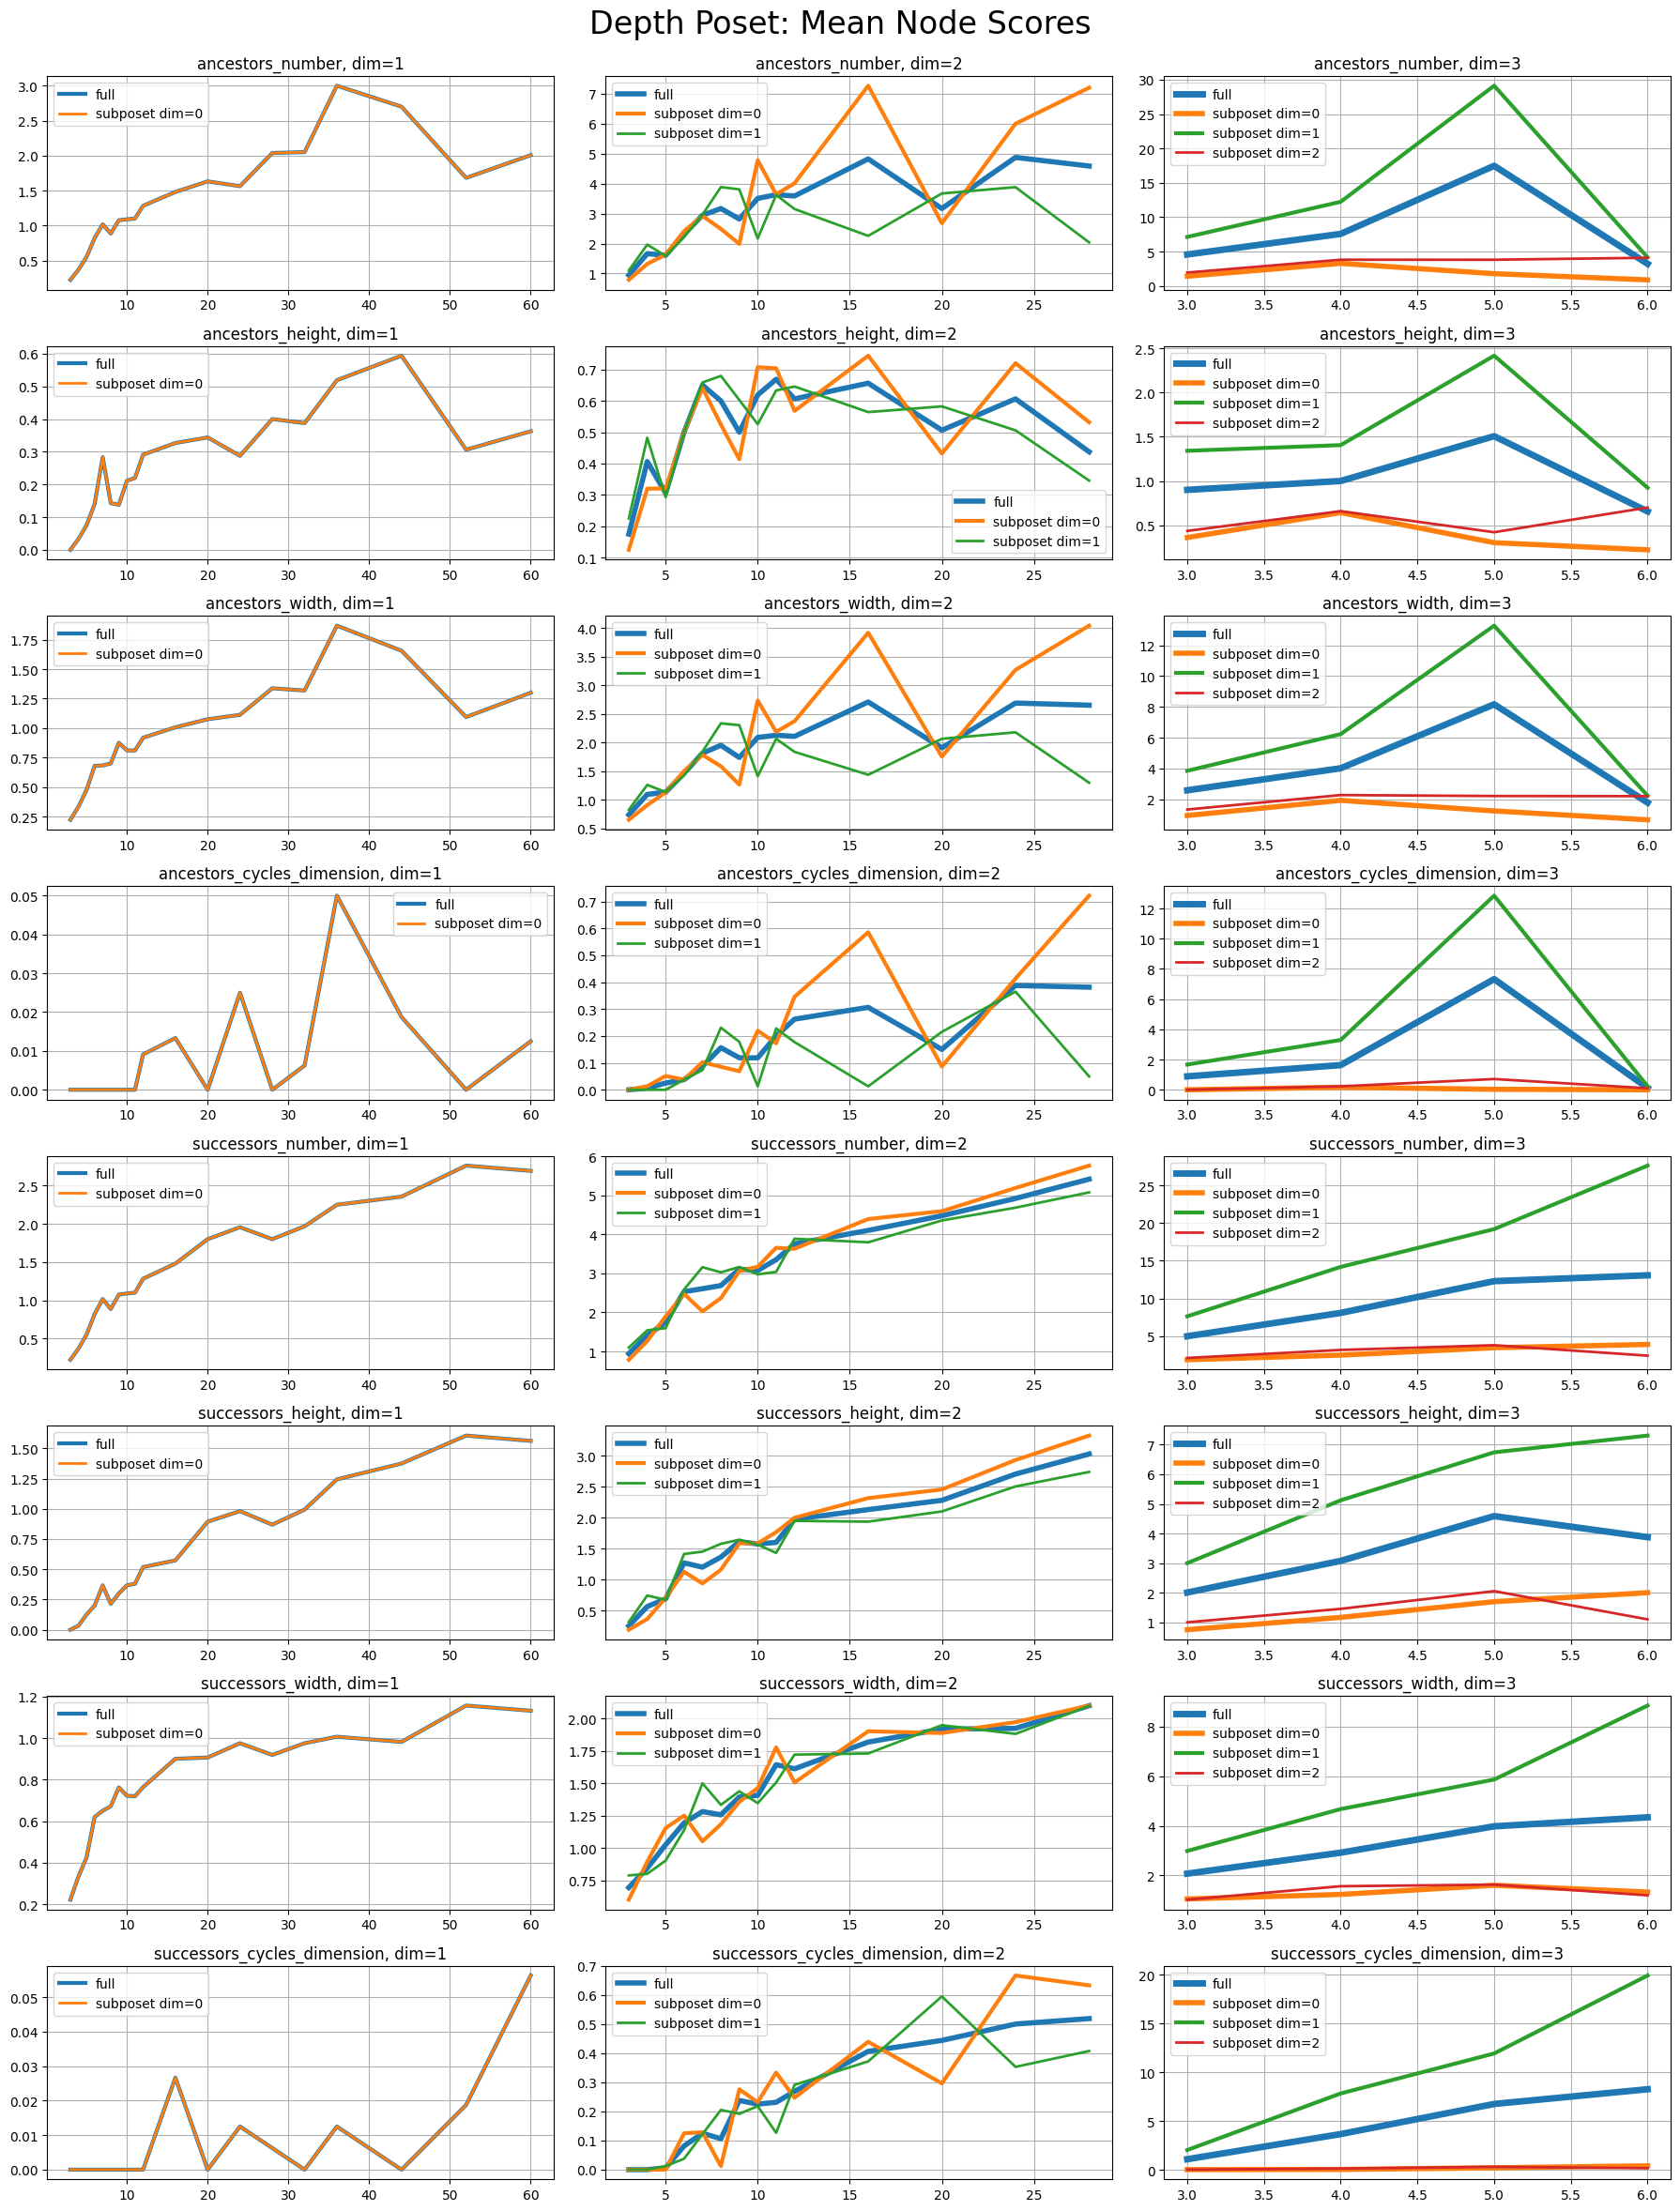

In [20]:
score_cols = interesting_node_scores_names

max_dim = df_node_scores['dim'].max()

# define the dataframe with interesting objects
objects = ['full'] + [f'subposet dim={dim}' for dim in range(max_dim + 1)]
df_objects = df_node_scores[df_node_scores['object'].isin(objects)]

fig, axs = plt.subplots(len(score_cols), max_dim)

fig.suptitle('Depth Poset: Mean Node Scores', fontsize=24)
fig.set_figwidth(18)
fig.set_figheight(24)

for iscore, score in enumerate(score_cols):
    for dim in range(1, max_dim + 1):
        title = f'{score}, dim={dim}'
        axs[iscore, dim - 1].set_title(title)
        df_use = df_objects[df_objects['dim'] == dim][['n', 'object', score]].groupby(['n', 'object']).mean('score').reset_index().pivot(columns='object', index='n', values=score)
        for icol, col in enumerate(df_use.columns):
            axs[iscore, dim - 1].plot(df_use.index, df_use[col], label=col, linewidth=(len(df_use.columns) + 1 - icol))
        axs[iscore, dim - 1].legend()
        axs[iscore, dim - 1].grid(True)
        
plt.tight_layout()
plt.subplots_adjust(top=0.95)

plt.savefig('raports/pics/torus scores/mean node scores.png')

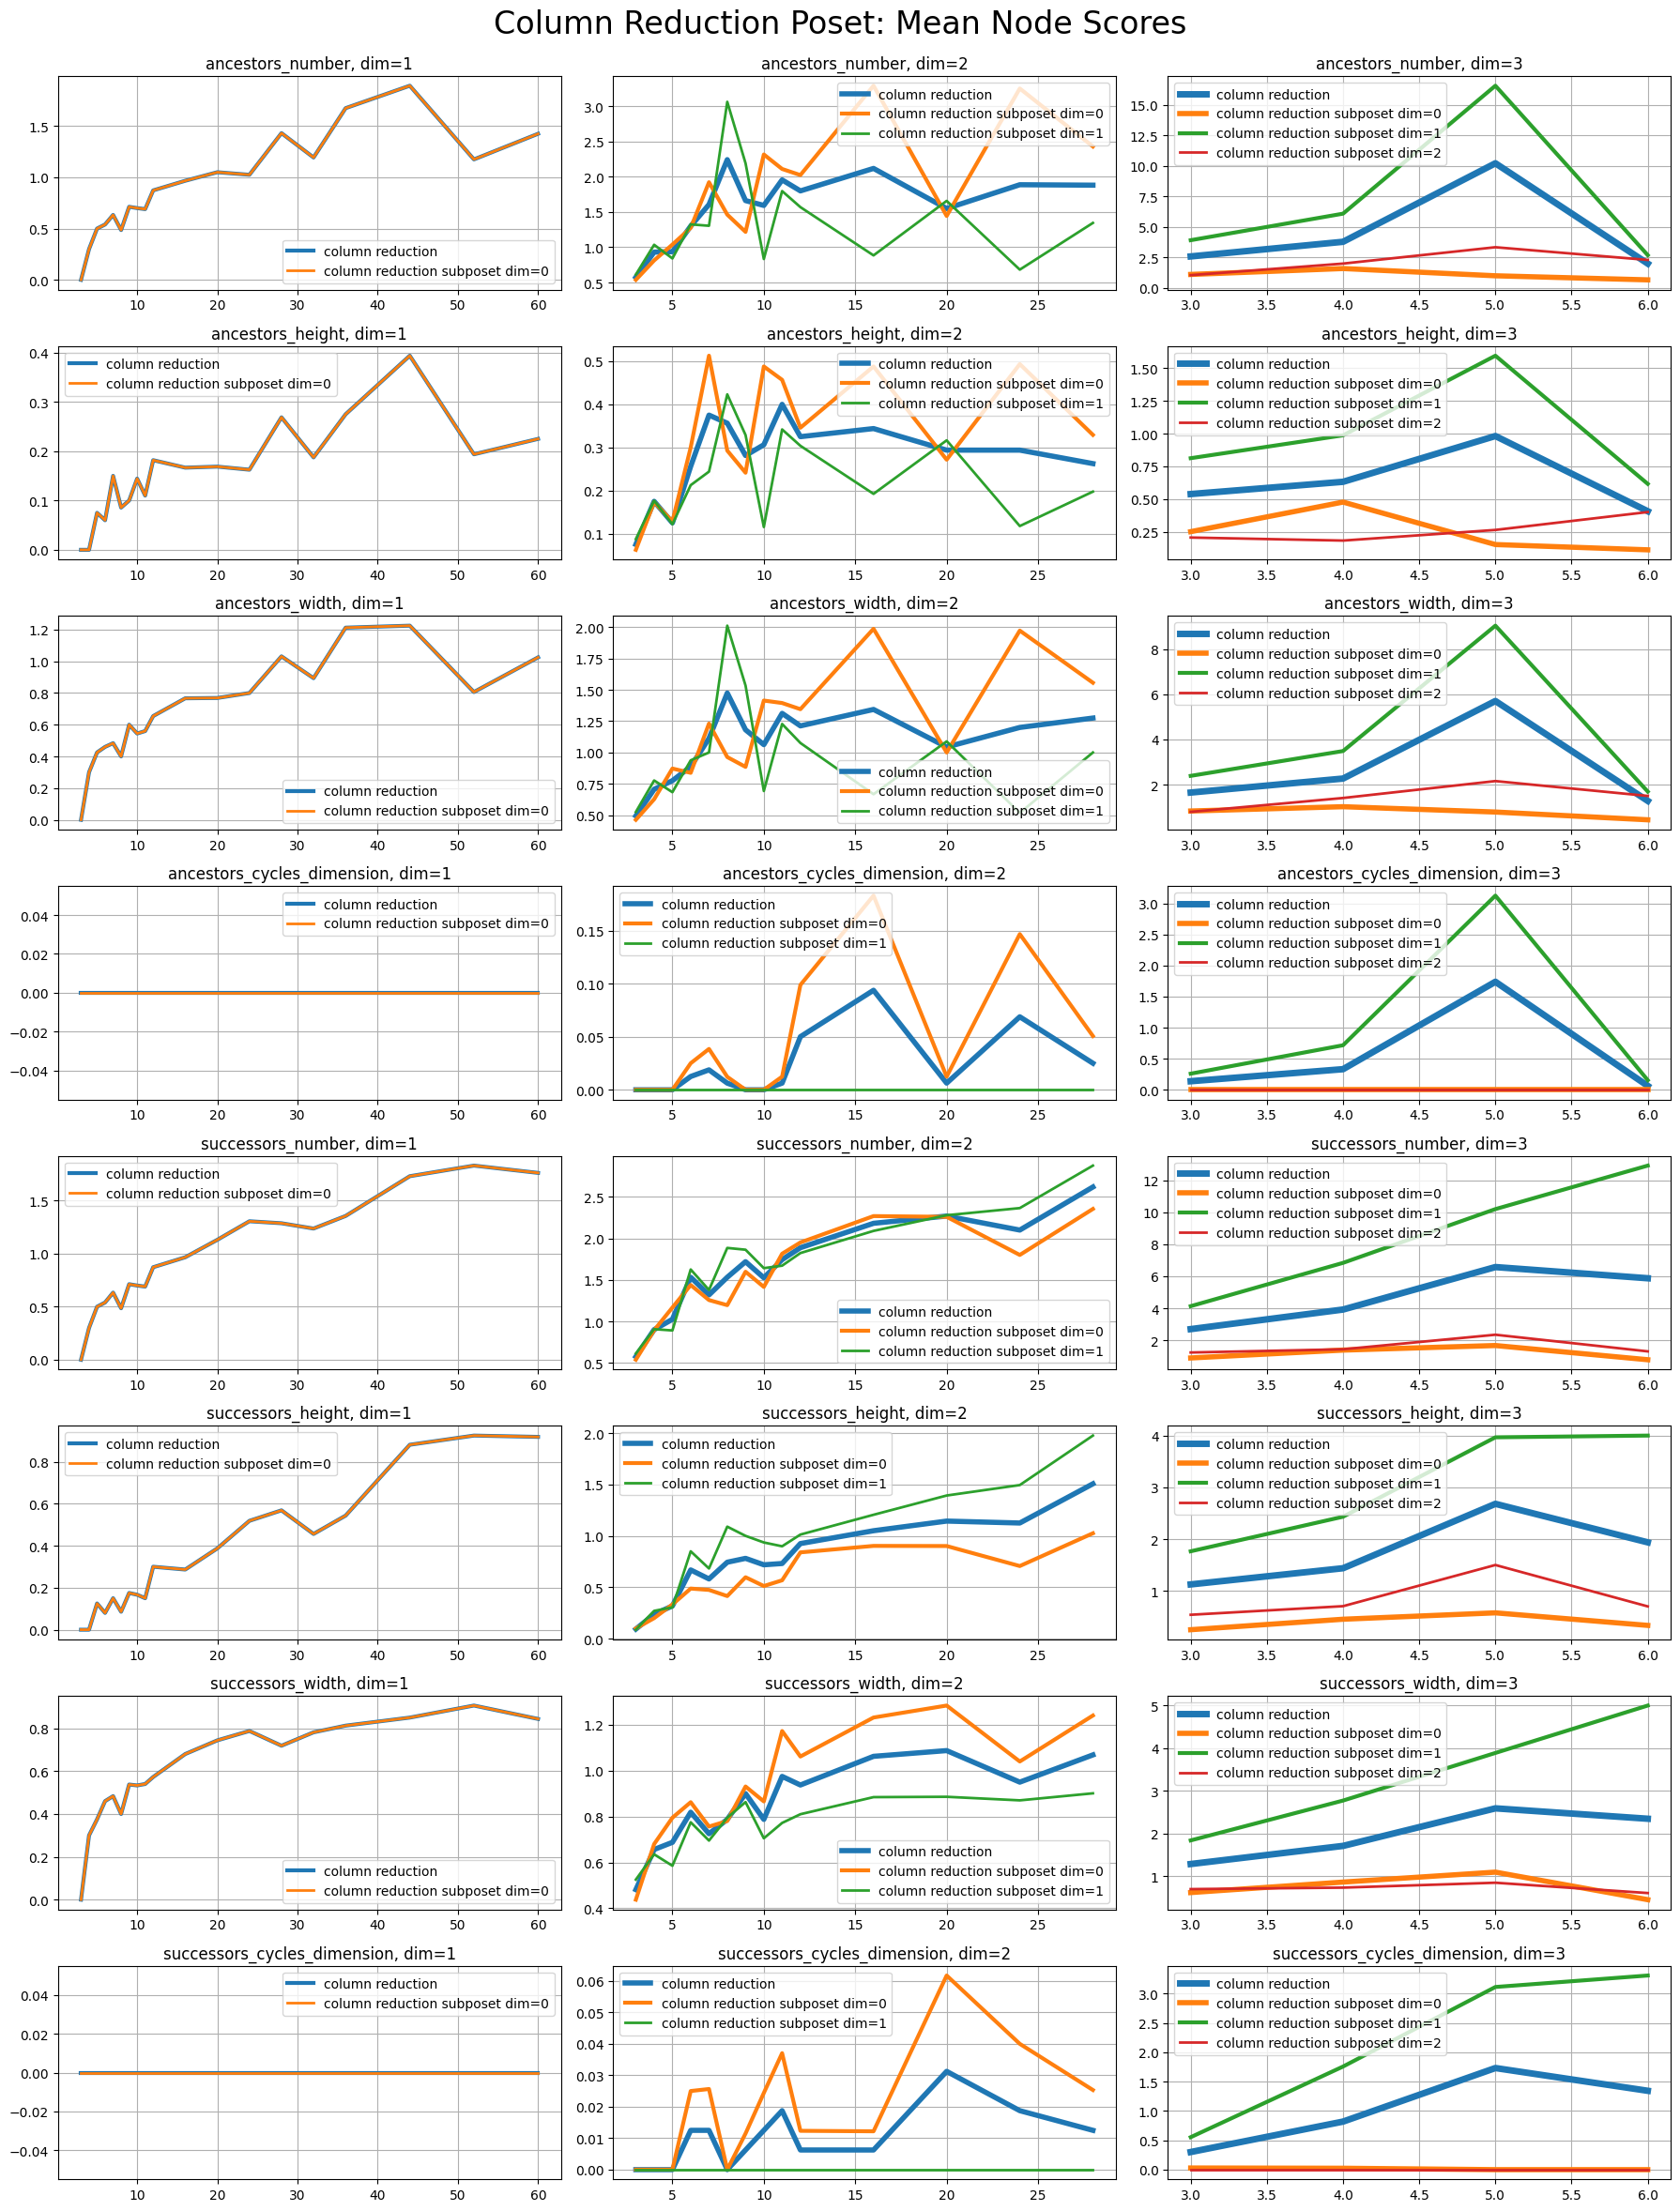

In [21]:
score_cols = interesting_node_scores_names

max_dim = df_node_scores['dim'].max()

# define the dataframe with interesting objects
objects = ['column reduction'] + [f'column reduction subposet dim={dim}' for dim in range(max_dim + 1)]
df_objects = df_node_scores[df_node_scores['object'].isin(objects)]

fig, axs = plt.subplots(len(score_cols), max_dim)

fig.suptitle('Column Reduction Poset: Mean Node Scores', fontsize=24)
fig.set_figwidth(18)
fig.set_figheight(24)

for iscore, score in enumerate(score_cols):
    for dim in range(1, max_dim + 1):
        title = f'{score}, dim={dim}'
        axs[iscore, dim - 1].set_title(title)
        df_use = df_objects[df_objects['dim'] == dim][['n', 'object', score]].groupby(['n', 'object']).mean('score').reset_index().pivot(columns='object', index='n', values=score)
        for icol, col in enumerate(df_use.columns):
            axs[iscore, dim - 1].plot(df_use.index, df_use[col], label=col, linewidth=(len(df_use.columns) + 1 - icol))
        axs[iscore, dim - 1].legend()
        axs[iscore, dim - 1].grid(True)
        
plt.tight_layout()
plt.subplots_adjust(top=0.95)

plt.savefig('raports/pics/torus scores/mean node scores - column reduction.png')

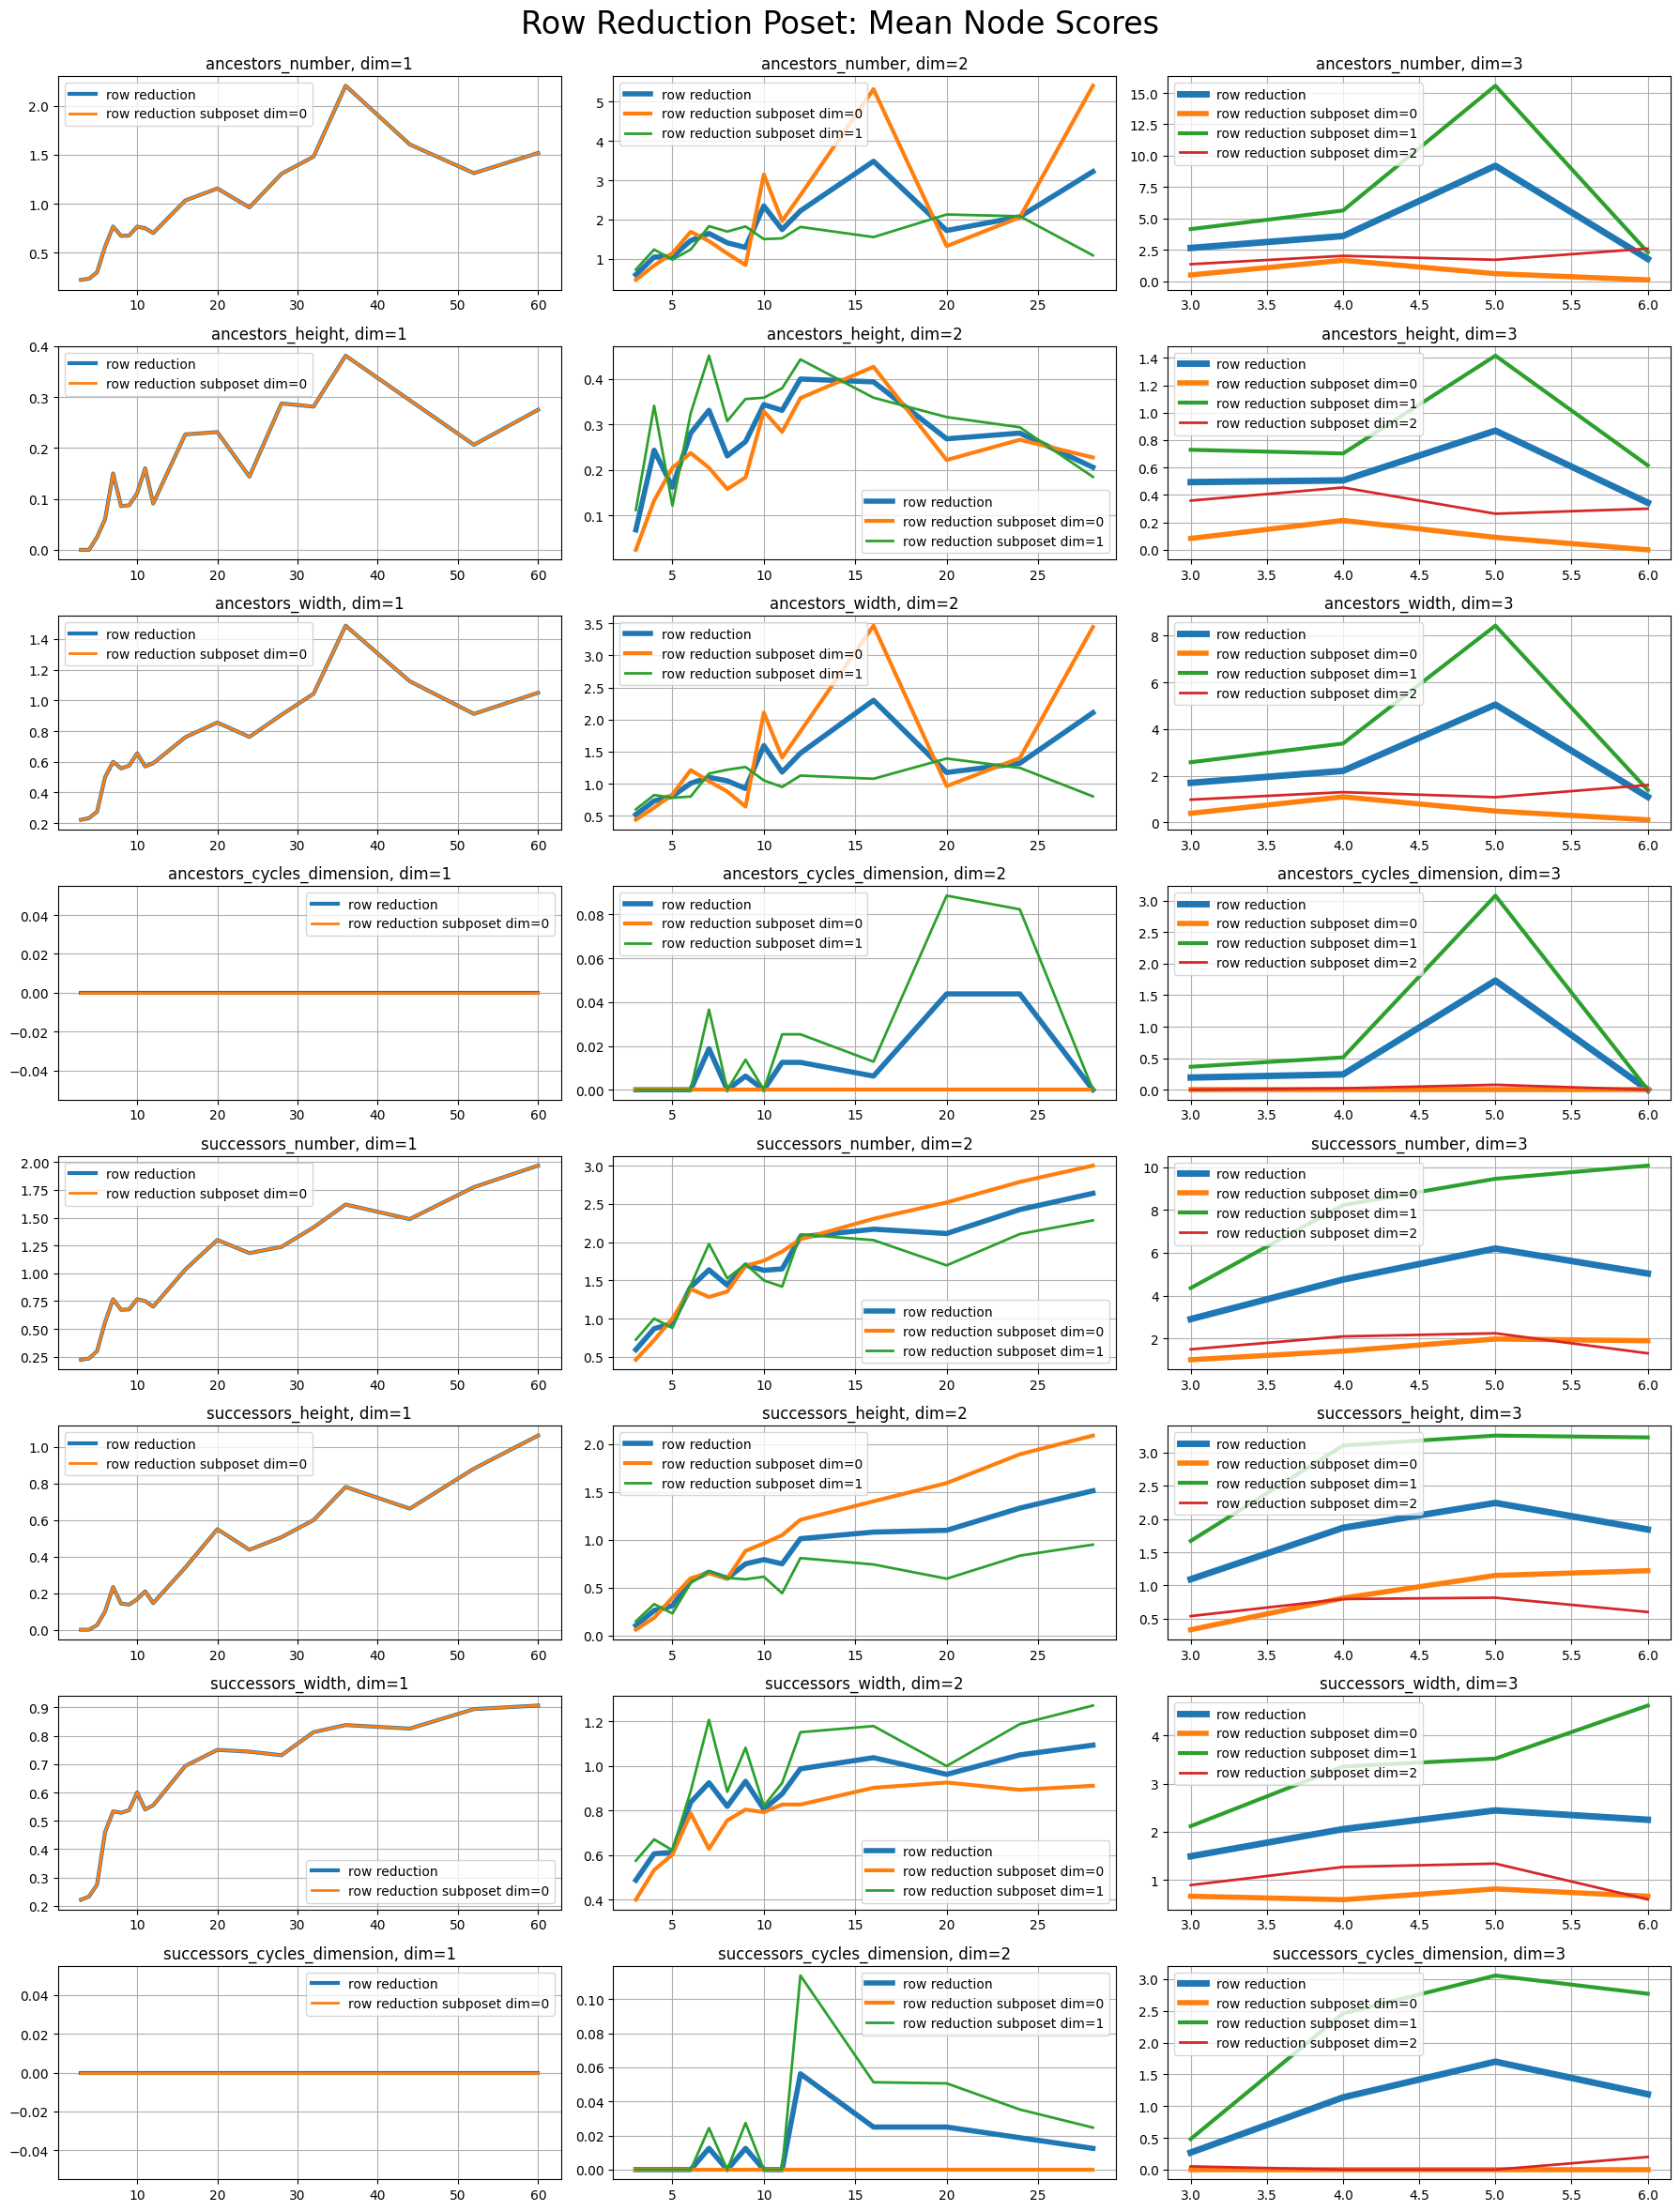

In [22]:
score_cols = interesting_node_scores_names

max_dim = df_node_scores['dim'].max()

# define the dataframe with interesting objects
objects = ['row reduction'] + [f'row reduction subposet dim={dim}' for dim in range(max_dim + 1)]
df_objects = df_node_scores[df_node_scores['object'].isin(objects)]

fig, axs = plt.subplots(len(score_cols), max_dim)

fig.suptitle('Row Reduction Poset: Mean Node Scores', fontsize=24)
fig.set_figwidth(18)
fig.set_figheight(24)

for iscore, score in enumerate(score_cols):
    for dim in range(1, max_dim + 1):
        title = f'{score}, dim={dim}'
        axs[iscore, dim - 1].set_title(title)
        df_use = df_objects[df_objects['dim'] == dim][['n', 'object', score]].groupby(['n', 'object']).mean('score').reset_index().pivot(columns='object', index='n', values=score)
        for icol, col in enumerate(df_use.columns):
            axs[iscore, dim - 1].plot(df_use.index, df_use[col], label=col, linewidth=(len(df_use.columns) + 1 - icol))
        axs[iscore, dim - 1].legend()
        axs[iscore, dim - 1].grid(True)
        
plt.tight_layout()
plt.subplots_adjust(top=0.95)

plt.savefig('raports/pics/torus scores/mean node scores - row reduction.png')

# Compile Raport Document

In [23]:
import src.poset_scores as poset_scores
import src.node_scores as node_scores
import inspect

In [24]:
def href_links(s: str, text='link') -> str:
    # replacing links in string with LaTeX format
    for w in s.split():
        if w[:6] == r'https:':
            if text is None:
                s = s.replace(w, f'\href{{{w}}}' + f'{{{w}}}'.replace('_', r'\_'))
            else:
                s = s.replace(w, f'\href{{{w}}}' + f'{{{text}}}')
    return s

In [25]:
# poset_scores description
s_poset_scores = r'\begin{itemize}' + '\n'

#for name, obj in inspect.getmembers(poset_scores, inspect.isfunction):
for obj, name in zip(interesting_poset_scores, interesting_poset_scores_names):
    if obj.__module__ == poset_scores.__name__:
        s_poset_scores += r"\item \textbf{" + name.replace('_', r'\_') + " }: " + href_links(obj.__doc__.strip()) + "\n"
s_poset_scores += r'\end{itemize}'

print(s_poset_scores)

\begin{itemize}
\item \textbf{number\_of\_nodes }: Returns the number of nodes in the poset.
\item \textbf{number\_of\_relations }: Returns the number of relations in the transitive reduction.
\item \textbf{number\_of\_components }: Returns the number of connetcted components in the poset
\item \textbf{cycles\_dimension }: Returns the dimension of space of cycles in reduction.
\item \textbf{number\_of\_minimal\_nodes }: Returns the number of minimal nodes.
\item \textbf{number\_of\_maximal\_nodes }: Returns the number of maximal nodes.
\item \textbf{height }: Returns the poset height - the length of the longest chain.
\item \textbf{width }: Returns the poset width - the length of the longest antichain (subset, s.t. all elements are pairwise incomparable).
    The algorithm is based on Dilworth's theorem and it's proof via Kőnig's theorem:
    \href{https://en.wikipedia.org/wiki/Dilworth%27s_theorem}{link}
\item \textbf{minimum\_maximal\_chain }: Returns the minimum size of maximal chai

In [26]:
# node_scores description
s_node_scores = r'\begin{itemize}' + '\n'

#for name, obj in inspect.getmembers(node_scores, inspect.isfunction):
for obj, name in zip(interesting_node_scores, interesting_node_scores_names):
    if obj.__module__ == node_scores.__name__:
        s_node_scores += r"\item \textbf{" + name.replace('_', r'\_') + "}: " + href_links(obj.__doc__.strip()) + "\n"
s_node_scores += r'\end{itemize}'

print(s_node_scores)

\begin{itemize}
\item \textbf{ancestors\_number}: Returns the number of nodes higher than given
\item \textbf{ancestors\_height}: Returns the size of maximum chain of subposet of nodes higher or equal than given
\item \textbf{ancestors\_width}: Returns the size of maximum chain of subposet of nodes higher or equal than given
\item \textbf{ancestors\_cycles\_dimension}: Returns the the dimension of space of cycles in reduction of subposet of nodes higher or equal than given
\item \textbf{successors\_number}: Returns the number of nodes higher than given
\item \textbf{successors\_height}: Returns the size of maximum chain of subposet of nodes lower or equal than given
\item \textbf{successors\_width}: Returns the size of maximum chain of subposet of nodes lower or equal than given
\item \textbf{successors\_cycles\_dimension}: Returns the the dimension of space of cycles in reduction of subposet of nodes lower or equal than given
\end{itemize}


In [27]:
# load texts, describing the process
with open('texts/barycentric-cubical-torus - model.txt', 'r') as file:
    s_model = file.read()

# load LaTeX template
with open('texts/template.tex', 'r') as file:
    s_latex = file.read()

In [28]:
# parameters to include pictures containing scores
vspace_pt = -96
resize_width = 1.38
hspace_width = round(min(0, 0.5*(1 - resize_width)), 2)


body = f"""
\\section{{Model}}
{s_model}

\\section{{Scores}}
\\subsection{{Poset Scores}}
{s_poset_scores}

\\subsection{{Node Scores}}
{s_node_scores}

\\section{{Experiments and Results}}
\\par There are {len(df_cases)} experiments done. In the Figure \\ref{{fig:cases_distribution}} we can see how cases are distributed by size and dimension.
\\begin{{figure}}[ht]
  \\centering
  \\includegraphics[width=\\textwidth]{{pics/torus scores/cases.png}}
  \\caption{{Size/dimension distribution of experiments}}
  \\label{{fig:cases_distribution}}
\end{{figure}}

\\subsection{{Depth Poset Features}}
\\par In the Figure \\ref{{fig:scores_poset_mean}} we can see the avarage poset scores values for each number of points $n$ in the depth poset.
\\begin{{figure}}[ht]
  \\vspace{{{vspace_pt}pt}}
  \\centering
  \\hspace*{{{hspace_width}\\textwidth}}
  \\resizebox{{{resize_width}\\textwidth}}{{!}}{{\\includegraphics[width=\\textwidth]{{pics/torus scores/mean poset scores.png}}}}
  \\caption{{Depth Poset: Mean poset scores}}
  \\label{{fig:scores_poset_mean}}
\\end{{figure}}

\\par In the Figure \\ref{{fig:scores_node_mean}} we can see the avarage mean node scores values in poset for each number of points $n$ in the depth poset.
\\begin{{figure}}[ht]
  \\vspace{{{vspace_pt}pt}}
  \\centering
  \\hspace*{{{hspace_width}\\textwidth}}
  \\resizebox{{{resize_width}\\textwidth}}{{!}}{{\\includegraphics[width=\\textwidth]{{pics/torus scores/mean node scores.png}}}}
  \\caption{{Depth Poset: Mean node scores}}
  \\label{{fig:scores_node_mean}}
\\end{{figure}}

\\subsection{{Column Reduction Poset Features}}
\\par In the Figure \\ref{{fig:scores_poset_mean_crp}} we can see the avarage poset scores values for each number of points $n$ in the column reduction poset.
\\begin{{figure}}[ht]
  \\vspace{{{vspace_pt}pt}}
  \\centering
  \\hspace*{{{hspace_width}\\textwidth}}
  \\resizebox{{{resize_width}\\textwidth}}{{!}}{{\\includegraphics[width=\\textwidth]{{pics/torus scores/mean poset scores - column reduction.png}}}}
  \\caption{{Column Reduction Poset: Mean poset scores}}
  \\label{{fig:scores_poset_mean_crp}}
\\end{{figure}}

\\par In the Figure \\ref{{fig:scores_node_mean_crp}} we can see the avarage mean node scores values in poset for each $n$ in the column reduction poset.
\\begin{{figure}}[ht]
  \\vspace{{{vspace_pt}pt}}
  \\centering
  \\hspace*{{{hspace_width}\\textwidth}}
  \\resizebox{{{resize_width}\\textwidth}}{{!}}{{\\includegraphics[width=\\textwidth]{{pics/torus scores/mean node scores - column reduction.png}}}}
  \\caption{{Column Reduction Poset: Mean node scores}}
  \\label{{fig:scores_node_mean_crp}}
\\end{{figure}}

\\subsection{{Row Reduction Poset Features}}
\\par In the Figure \\ref{{fig:scores_poset_mean_rrp}} we can see the avarage poset scores values for each number of points $n$ in the row reduction poset.
\\begin{{figure}}[ht]
  \\vspace{{{vspace_pt}pt}}
  \\centering
  \\hspace*{{{hspace_width}\\textwidth}}
  \\resizebox{{{resize_width}\\textwidth}}{{!}}{{\\includegraphics[width=\\textwidth]{{pics/torus scores/mean poset scores - row reduction.png}}}}
  \\caption{{Row Reduction Poset: Mean poset scores}}
  \\label{{fig:scores_poset_mean_rrp}}
\\end{{figure}}

\\par In the Figure \\ref{{fig:scores_node_mean_rrp}} we can see the avarage mean node scores values in poset for each number of points $n$ in the row reduction poset.
\\begin{{figure}}[ht]
  \\vspace{{{vspace_pt}pt}}
  \\centering
  \\hspace*{{{hspace_width}\\textwidth}}
  \\resizebox{{{resize_width}\\textwidth}}{{!}}{{\\includegraphics[width=\\textwidth]{{pics/torus scores/mean node scores - row reduction.png}}}}
  \\caption{{Row Reduction Poset: Mean node scores}}
  \\label{{fig:scores_node_mean_rrp}}
\\end{{figure}}

"""

raport = s_latex.replace('BODY', body)
print(raport)

\documentclass{article}
\usepackage{amsfonts} 
\usepackage{amsmath}
\usepackage{hyperref}
\usepackage{graphicx}
\usepackage{booktabs}
\usepackage{makecell}
\usepackage{multirow}
%\usepackage{placeins}

\begin{document}


\section{Model}
\par The $d$ dimensional torus $\mathbb{T}^d$ can be defined as $\left(\mathbb{R}/n\mathbb{Z}\right)^d$ for some natural $n$. And we can represent this as a cell-complex with cubical $d$-dimensional cells $\left(\mathbb{Z}/n\mathbb{Z}\right)^d + [0, 1]^d$ and all their $k$-faces for $k=0, ..., d$.
\par We randomly assume the filtration value for each $k$-face uniformly distributed in $[k, k+1]$. This filtration on segmented torus will corespond some real filtration $f\mathbb{T}^d\to\mathbb{R}$, s.t. the $d$-dimensional cells will corespond the local maximums, vertices will corespond the local minimums and other $k$-faces will be saddles.
\begin{figure}[h!]
    \centering
    \includegraphics[width=0.6\textwidth]{pics/torus scores/2d-example.png}
    \ca

In [29]:
with open('raports/barycentric-torus-scores.tex', 'w') as file:
    file.write(raport)

In [30]:
%cd raports
os.system('pdflatex barycentric-torus-scores.tex')
%cd ..

/nfs/scistore16/edelgrp/fzimin/depth-poset/raports
This is pdfTeX, Version 3.141592653-2.6-1.40.23 (TeX Live 2021) (preloaded format=pdflatex)
 restricted \write18 enabled.


/mnt/nfs/clustersw/Debian/bookworm/jupyterhub/1.0/lib/python3.11/site-packages/IPython/core/magics/osm.py:417: UserWarning: This is now an optional IPython functionality, setting dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


entering extended mode
(./barycentric-torus-scores.tex
LaTeX2e <2021-06-01> patch level 1
L3 programming layer <2021-10-18>
(/nfs/scistore07/clustersw/shared/texlive/2021/texmf-dist/tex/latex/base/articl
e.cls
Document Class: article 2021/02/12 v1.4n Standard LaTeX document class

(/nfs/scistore07/clustersw/shared/texlive/2021/texmf-dist/tex/latex/base/size10
.clo))
(/nfs/scistore07/clustersw/shared/texlive/2021/texmf-dist/tex/latex/amsfonts/am
sfonts.sty)
(/nfs/scistore07/clustersw/shared/texlive/2021/texmf-dist/tex/latex/amsmath/ams
math.sty
For additional information on amsmath, use the `?' option.

(/nfs/scistore07/clustersw/shared/texlive/2021/texmf-dist/tex/latex/amsmath/ams
text.sty
(/nfs/scistore07/clustersw/shared/texlive/2021/texmf-dist/tex/latex/amsmath/ams
gen.sty))
(/nfs/scistore07/clustersw/shared/texlive/2021/texmf-dist/tex/latex/amsmath/ams
bsy.sty)
(/nfs/scistore07/clustersw/shared/texlive/2021/texmf-dist/tex/latex/amsmath/ams
opn.sty))
(/nfs/scistore07/clustersw/share